# Newsgroup Text Analysis

This is a small exercise in text analysis using the NLTK library.

Installing the NLTK corpora can be a little tricky for the uninitiated. After installing the library, you must use the downloader to download one or more text corpora. The downloader is part of the library. This utility has a GUI which tends to run fine on Windows and Linux. On Mac, it is a better bet to use the command-line version by calling download_shell(), e.g.

```bash
$ python
Python 3.7.6 (default, Jan  8 2020, 13:42:34)
[Clang 4.0.1 (tags/RELEASE_401/final)] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> import nltk
>>> nltk.download_shell()
```

For this exercise, it probably makes sense to download the 'popular' collection of corpora ('d popular'). At the very least, you'll need the stop words ('d stopwords'). You'll also need the [GloVe pre-trained word vectors](http://nlp.stanford.edu/data/glove.6B.zip) from Stanford (careful, it's and 822MB download!).

References:
* See [this link](https://github.com/tensorchiefs/dl_course_2018/blob/master/notebooks/13_sentiment_analysis_with_imdb_reviews_solution.ipynb) from a previous DL lecture
* Also https://realpython.com/python-keras-text-classification/
* ZHAW ML Lab [5_NaiveBayes_Newsgroup.py](https://moodle2.zhaw.ch/mod/folder/view.php?id=1382473)
* A good introductory post on CNNs and text classification can be found here: http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import nltk
import re

Using TensorFlow backend.


In [2]:
# Read in some data
categories = ['soc.religion.christian', 'comp.graphics', 'sci.med', 'comp.windows.x', 'sci.space', 'alt.atheism']

newsgroup_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
newsgroup_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))


In [3]:
print("%d documents" % len(newsgroup_train.filenames))
print("%d categories" % len(newsgroup_train.target_names))
print()

3443 documents
6 categories



In [4]:
# Print an example message
print(newsgroup_train["data"][1])

We have recently obtained a copy of color_xterm (from export.lcs.mit.edu) after
seeing it mentioned in a previous article. On compilation, it reports the
following undefined symbols:
	_get_wmShellWidgetClass
	_get_applicationShellWidgetClass

	but still runs. When sending escape sequences to set the colour,
any colour comes out as black text on a black background. Any Ideas?

Has anyone used this program in colour successfully?

Can anyone point me to any other colour terminal emulators?

We are running OpenWindows 3 on Sun Sparcs running SunOS 4.1.3.

				advaTHANKSnce  Ben Kelley.


In [5]:
# Set up standard stop words
stop_words = set(stopwords.words('english')) 
print(stop_words)

{'myself', 'theirs', 'because', 'they', 'herself', 'him', 'who', 'hasn', 'for', 'most', 'himself', 'through', 'into', 'here', 'more', "you're", "doesn't", "you'd", 'a', 'or', 'y', 'which', 'm', 'i', 'when', 'are', 'having', 'mightn', 'does', 'can', 'so', 'to', "needn't", 'didn', "you'll", 'being', 'yours', 'its', "it's", 'should', 'did', 'doing', 'my', 'while', 'don', 's', 'few', 'nor', 'over', 'there', 'own', "didn't", 'themselves', 'on', 'he', 'both', 'how', 'in', 'an', 'her', "wasn't", "won't", 'aren', 'whom', 'just', 'their', 'by', 'will', "that'll", 'am', 'weren', 'what', 'other', 'with', 'your', 'then', 'doesn', 'itself', 'same', "mightn't", 'too', 'be', "isn't", 'we', "wouldn't", 'above', 'is', 'as', 'from', 'it', 'his', 'down', 'no', 'if', "hadn't", "shouldn't", 'why', 'at', "mustn't", 'shouldn', 've', "shan't", 'ain', "you've", 'our', 'wouldn', 'has', 'each', 'below', 'until', "couldn't", 'wasn', 'needn', "hasn't", 'these', 'those', "don't", 'ma', 'once', 'll', 'where', 'any',

In [6]:
# Put some additional words in the list
stop_words.update(['find','would','be','one','say','made','think','subject','see','fnal','articl','feel','given','led',
                  'view','way','either','however','yet','know','get','use','therefore','even','like','could'])

In [7]:
# Pre-processing

# Get rid of stop words e.g. with nltk (and stem)
ps = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+') ## Std pattern is '\w+|\$[\d\.]+|\S+'

newsgroup_trainN = []


for message in newsgroup_train.data:
    
    #r'[^A-Za-z0-9#]+'
    
    # Sub all the special characters (except _)
    document = re.sub(r'\W', ' ', message)
    document = re.sub(r'_', ' ', document)
    # Sub all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Sub single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Sub digits (https://stackoverflow.com/questions/39582859/python-regex-remove-numbers-and-numbers-with-punctaution?rq=1)
    document = re.sub(r'\b\d+(?:\.\d+)?\s+', ' ', document)
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Convert to Lowercase
    document = document.lower()
    document = document.strip()
    
    # Original code
    text_token = tokenizer.tokenize(document)
    messageN = ''
    
    for word in text_token:
        if word not in stop_words:
            #messageN = messageN + ' ' + ps.stem(word)
            # w/o stemming
            messageN = messageN + ' ' + word
            
    newsgroup_trainN.append(messageN)

newsgroup_train.data = newsgroup_trainN

# Print the same message as above, now in its processed form
print(newsgroup_train["data"][1])

 recently obtained copy color xterm export lcs mit edu seeing mentioned previous article compilation reports following undefined symbols wmshellwidgetclass applicationshellwidgetclass still runs sending escape sequences set colour colour comes black text black background ideas anyone used program colour successfully anyone point colour terminal emulators running openwindows sun sparcs running sunos advathanksnce ben kelley


In [16]:
## OPTIONAL: Baseline vocab
#from sklearn.feature_extraction.text import CountVectorizer  
#vectorizer = CountVectorizer(min_df=5, max_df=0.7)
#X = vectorizer.fit_transform(newsgroup_train.data).toarray()
#
#print(len(vectorizer.get_feature_names())) #length of all tokens
#np.array(vectorizer.get_feature_names()[0:200]) #the first 200 tokens


7786


array(['1024x768', '10th', '17th', '18084tm', '1960s', '1993', '1b', '1d',
       '1g', '1mb', '1st', '20th', '24bit', '24th', '24x', '2a', '2d',
       '2mb', '2nd', '320x200x256', '386bsd', '3d', '3do', '3ds', '3e',
       '3rd', '4368', '4mb', '4th', '5th', '640x480', '64k', '6th', '7th',
       'abandon', 'abandoned', 'abdominal', 'abilities', 'ability',
       'able', 'aboard', 'abort', 'abortion', 'abraham', 'absence',
       'absent', 'absolute', 'absolutely', 'absolutes', 'absorbed',
       'absorption', 'abstinence', 'abstract', 'abstraction', 'abstracts',
       'absurd', 'abuse', 'ac', 'acad3', 'academic', 'academy',
       'acceleration', 'accelerator', 'accelerators', 'accept',
       'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts',
       'access', 'accessible', 'accident', 'accidental', 'accidently',
       'accompanied', 'accompanying', 'accomplish', 'accomplished',
       'accordance', 'according', 'account', 'accountable', 'accounting',
       'accounts

In [244]:
## OPTIONAL: Run some metrics, determine most common words
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.naive_bayes import MultinomialNB
#from sklearn import metrics
#
## Converting text to vectors
#vectorizer2 = TfidfVectorizer()
#vectors = vectorizer2.fit_transform(newsgroup_train.data)
#vectors.shape
#
## Filtering text for more realistic training
#vectors_test = vectorizer2.transform(newsgroup_test.data)
#clf = MultinomialNB(alpha=.01)
#clf.fit(vectors, newsgroup_train.target)
#pred = clf.predict(vectors_test)
#metrics.f1_score(newsgroup_test.target, pred, average='macro')
#
#feature_names = np.asarray(vectorizer2.get_feature_names())
#for i, category in enumerate(newsgroup_train.target_names):
#    top10 = np.argsort(clf.coef_[i])[-10:]
#    print("%s: %s" % (category, " ".join(feature_names[top10])))


alt.atheism: objective morality said well atheists islam religion atheism people god
comp.graphics: format please looking program anyone file files image thanks graphics
comp.windows.x: x11r5 display using application windows widget thanks motif server window
sci.med: dsl shameful n3jxp chastity pitt geb banks gordon edu msg
sci.space: also much lunar earth shuttle moon orbit launch nasa space
soc.religion.christian: faith believe christ christian bible christians people church jesus god


In [8]:
# Tokenize words (tensorflow keras Tokenizer)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(newsgroup_train.data)

# Get size of vocabulary 
# 1 needs to be added because of resrver 0 index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

# Transforms each text in texts to a sequence of integers
X_train = tokenizer.texts_to_sequences(newsgroup_train.data)
X_test = tokenizer.texts_to_sequences(newsgroup_test.data)
print (X_train[0][:10])

Found 35918 unique tokens.
[11714, 272, 310, 1051, 161, 2834, 44, 3062, 9851, 2138]


In [9]:
# Padding
#maxlen = max([len(i) for i in X_train])
maxlen = 2000
print(maxlen)

2000


In [10]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print (X_train.shape)
print (X_train[0][200:250])

(3443, 2000)
[  291    51    44  3724   372    46   146  1712 11722   811   202    80
  1227  5819     1   204 14406  3181   381   340  6327  7657   196  1293
   217    44    29 11723  6936    38  3182   604  2140   244  2392   745
   138   228   444  1408   444  5443 14407  8606   440  2140  1408   444
   348  1036]


In [11]:
labels = to_categorical(np.array(newsgroup_train.target))

print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (3443, 2000)
Shape of label tensor: (3443, 6)


## Bag of Words (BOW) Approach


In [12]:
model = Sequential()

embedding_dim = 50

# Feature extraction
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())

# Classification
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 50)          1795900   
_________________________________________________________________
flatten (Flatten)            (None, 100000)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                1000010   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 2,795,976
Trainable params: 2,795,976
Non-trainable params: 0
_________________________________________________________________


In [267]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.8333 - accuracy: 0.1673 - val_loss: 1.7901 - val_accuracy: 0.1737
Epoch 2/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.7896 - accuracy: 0.1647 - val_loss: 1.7895 - val_accuracy: 0.1737
Epoch 3/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.7891 - accuracy: 0.1690 - val_loss: 1.7891 - val_accuracy: 0.1737
Epoch 4/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.7889 - accuracy: 0.1690 - val_loss: 1.7890 - val_accuracy: 0.1737
Epoch 5/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.7888 - accuracy: 0.1589 - val_loss: 1.7890 - val_accuracy: 0.1737
Epoch 6/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 1.7887 - accuracy: 0.1743 - val_loss: 1.7889 - val_accuracy: 0.1737
Epoch 7/10
3443/3443 [==============================] - 16s 5ms/sample

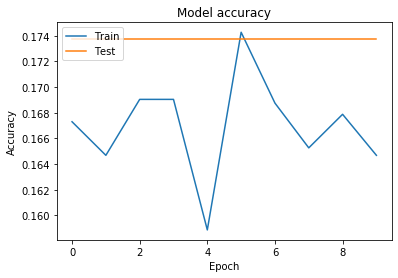

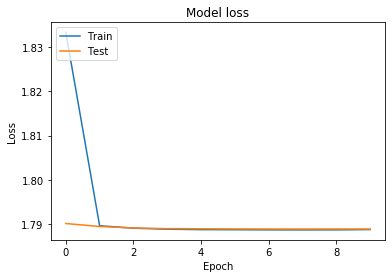

In [268]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Word Embedding w/ pre-computed embedding space (GloVe)

Now, we use Stanford's precomputed embedding space for our model.


In [16]:
# We don't need the full GloVe vocabulary, only the words we really need
# Helper function for creating the embedding matrix
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [17]:
# Create the embedding matrix for our vocab
embedding_dim = 100
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [18]:
# Check how many of our words are covered by the GloVe vocab
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7690294559830726

In [65]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         3591800   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66        
Total params: 3,592,876
Trainable params: 1,076
Non-trainable params: 3,591,800
_________________________________________________________________


In [66]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/50
3443/3443 [==============================] - 3s 978us/sample - loss: 1.7729 - accuracy: 0.2289 - val_loss: 1.7201 - val_accuracy: 0.2964
Epoch 2/50
3443/3443 [==============================] - 3s 875us/sample - loss: 1.6471 - accuracy: 0.3090 - val_loss: 1.5684 - val_accuracy: 0.3125
Epoch 3/50
3443/3443 [==============================] - 3s 874us/sample - loss: 1.4766 - accuracy: 0.3636 - val_loss: 1.4086 - val_accuracy: 0.3693
Epoch 4/50
3443/3443 [==============================] - 3s 876us/sample - loss: 1.3161 - accuracy: 0.4043 - val_loss: 1.2850 - val_accuracy: 0.4361
Epoch 5/50
3443/3443 [==============================] - 3s 874us/sample - loss: 1.2541 - accuracy: 0.4455 - val_loss: 1.2528 - val_accuracy: 0.4531
Epoch 6/50
3443/3443 [==============================] - 3s 878us/sample - loss: 1.2209 - accuracy: 0.4682 - val_loss: 1.2209 - val_accuracy: 0.4675
Epoch 7/50
3443/3443 [==============================] - 3s 875us

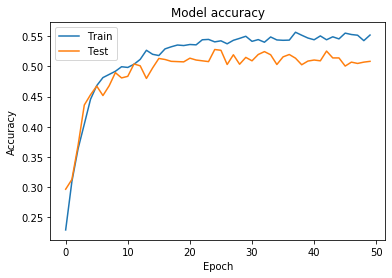

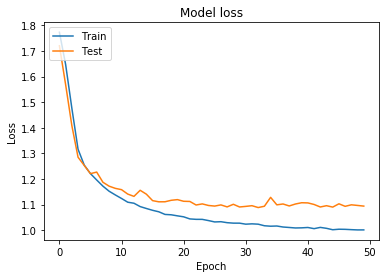

In [67]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Same model with training the word embeddings

In [68]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         3591800   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 66        
Total params: 3,592,876
Trainable params: 3,592,876
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/50
3443/3443 [==============================] - 18s 5ms/sample - loss: 1.7692 - accuracy: 0.2094 - val_loss: 1.7205 - val_accuracy: 0.2850
Epoch 2/50
3443/3443 [==============================] - 18s 5ms/sample - loss: 1.5952 - accuracy: 0.3607 - val_loss: 1.4662 - val_accuracy: 0.4470
Epoch 3/50
3443/3443 [==============================] - 17s 5ms/sample - loss: 1.1746 - accuracy: 0.5440 - val_loss: 1.1474 - val_accuracy: 0.5687
Epoch 4/50
3443/3443 [==============================] - 18s 5ms/sample - loss: 0.8418 - accuracy: 0.7020 - val_loss: 1.0211 - val_accuracy: 0.6019
Epoch 5/50
3443/3443 [==============================] - 17s 5ms/sample - loss: 0.6183 - accuracy: 0.7979 - val_loss: 0.8897 - val_accuracy: 0.6735
Epoch 6/50
3443/3443 [==============================] - 18s 5ms/sample - loss: 0.4472 - accuracy: 0.8763 - val_loss: 0.8303 - val_accuracy: 0.6993
Epoch 7/50
3443/3443 [==============================] - 17s 5ms/sample

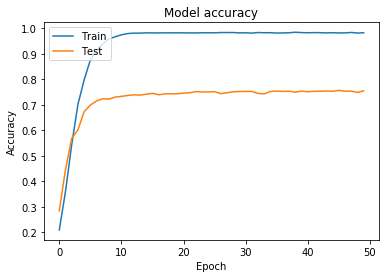

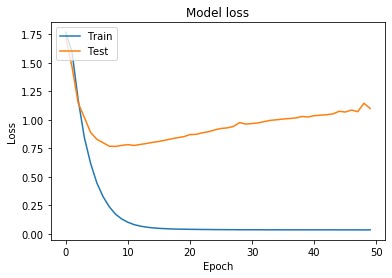

In [70]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN

In [230]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 1500, 100)         3591800   
_________________________________________________________________
conv1d (Conv1D)              (None, 1496, 128)         64128     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 66        
Total params: 3,657,284
Trainable params: 3,657,284
Non-trainable params: 0
_________________________________________________________________


In [232]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/10
3443/3443 [==============================] - 48s 14ms/sample - loss: 1.0438 - accuracy: 0.6149 - val_loss: 0.8206 - val_accuracy: 0.7097
Epoch 2/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.2676 - accuracy: 0.9088 - val_loss: 0.8470 - val_accuracy: 0.7372
Epoch 3/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.0727 - accuracy: 0.9779 - val_loss: 0.8245 - val_accuracy: 0.7564
Epoch 4/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.0506 - accuracy: 0.9802 - val_loss: 0.8699 - val_accuracy: 0.7521
Epoch 5/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.0460 - accuracy: 0.9811 - val_loss: 0.8750 - val_accuracy: 0.7577
Epoch 6/10
3443/3443 [==============================] - 46s 13ms/sample - loss: 0.0428 - accuracy: 0.9814 - val_loss: 0.9305 - val_accuracy: 0.7486
Epoch 7/10
3443/3443 [==============================] - 46s 13ms

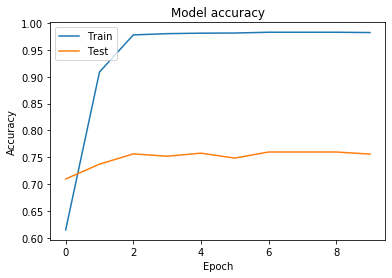

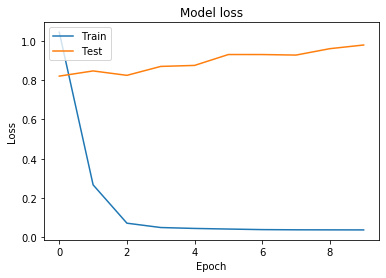

In [233]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Another Word Embedding Model

See https://qiita.com/takeshikondo/items/419bebc4f9e6c78d5ea9


In [302]:
model = Sequential()

model.add(layers.InputLayer(input_shape=(maxlen,), dtype='int32'))
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(35))  # global max pooling

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 1000, 50)          1795900   
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 996, 128)          32128     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 1, 128)          

In [303]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=128)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/10
3443/3443 [==============================] - 17s 5ms/sample - loss: 1.4081 - accuracy: 0.4243 - val_loss: 1.0654 - val_accuracy: 0.5378
Epoch 2/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 0.8551 - accuracy: 0.6306 - val_loss: 0.9257 - val_accuracy: 0.6242
Epoch 3/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 0.7286 - accuracy: 0.6759 - val_loss: 0.9142 - val_accuracy: 0.6281
Epoch 4/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 0.6470 - accuracy: 0.7241 - val_loss: 0.9157 - val_accuracy: 0.6342
Epoch 5/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 0.5790 - accuracy: 0.7488 - val_loss: 0.8716 - val_accuracy: 0.6704
Epoch 6/10
3443/3443 [==============================] - 16s 5ms/sample - loss: 0.4772 - accuracy: 0.8132 - val_loss: 0.8620 - val_accuracy: 0.6709
Epoch 7/10
3443/3443 [==============================] - 16s 5ms/sample

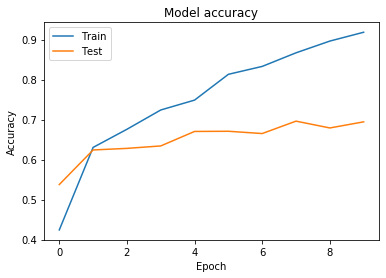

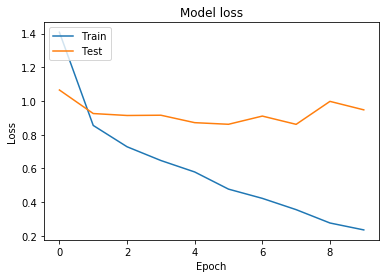

In [304]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Another WE model

See https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7

In [82]:
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

#model.add(layers.Conv1D(128, 2, activation='relu'))
#model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.Conv1D(128, 4, activation='relu'))
#model.add(layers.Conv1D(128, 5, activation='relu'))
#model.add(layers.Conv1D(128, 6, activation='relu'))

#model.add(layers.MaxPooling1D())
#model.add(layers.MaxPooling1D())
#model.add(layers.MaxPooling1D())
#model.add(layers.MaxPooling1D())
#model.add(layers.MaxPooling1D())

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 2000, 100)         3591800   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1997, 128)         51328     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 66        
Total params: 3,644,484
Trainable params: 3,644,484
Non-trainable params: 0
____________________________________________

In [83]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=150,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/150
3443/3443 [==============================] - 51s 15ms/sample - loss: 1.3834 - accuracy: 0.4447 - val_loss: 1.0352 - val_accuracy: 0.6172
Epoch 2/150
3443/3443 [==============================] - 50s 15ms/sample - loss: 0.9006 - accuracy: 0.6550 - val_loss: 0.7260 - val_accuracy: 0.7259
Epoch 3/150
3443/3443 [==============================] - 50s 14ms/sample - loss: 0.6419 - accuracy: 0.7482 - val_loss: 0.6842 - val_accuracy: 0.7412
Epoch 4/150
3443/3443 [==============================] - 50s 14ms/sample - loss: 0.4980 - accuracy: 0.8034 - val_loss: 0.6986 - val_accuracy: 0.7442
Epoch 5/150
3443/3443 [==============================] - 50s 14ms/sample - loss: 0.4308 - accuracy: 0.8301 - val_loss: 0.7002 - val_accuracy: 0.7564
Epoch 6/150
3443/3443 [==============================] - 50s 14ms/sample - loss: 0.3763 - accuracy: 0.8443 - val_loss: 0.7082 - val_accuracy: 0.7656
Epoch 7/150
3443/3443 [==============================] - 5

3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1435 - accuracy: 0.9355 - val_loss: 5.8074 - val_accuracy: 0.7525
Epoch 110/150
3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1471 - accuracy: 0.9390 - val_loss: 5.6275 - val_accuracy: 0.7599
Epoch 111/150
3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1443 - accuracy: 0.9364 - val_loss: 5.3960 - val_accuracy: 0.7643
Epoch 112/150
3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1486 - accuracy: 0.9347 - val_loss: 5.7158 - val_accuracy: 0.7556
Epoch 113/150
3443/3443 [==============================] - 50s 15ms/sample - loss: 0.1373 - accuracy: 0.9422 - val_loss: 5.4206 - val_accuracy: 0.7621
Epoch 114/150
3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1523 - accuracy: 0.9320 - val_loss: 5.6690 - val_accuracy: 0.7647
Epoch 115/150
3443/3443 [==============================] - 49s 14ms/sample - loss: 0.1391 - accuracy: 0.9344

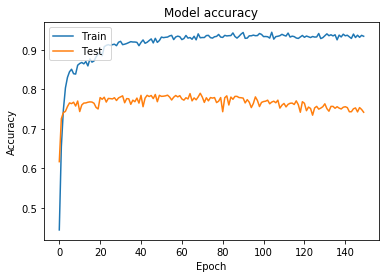

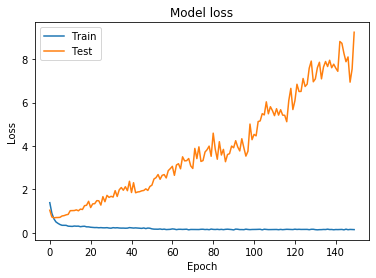

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Same model w/ slight adjustments

In [15]:
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

model.add(layers.Conv1D(128, 2, activation='relu'))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.Conv1D(128, 4, activation='relu'))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.Conv1D(128, 6, activation='relu'))

model.add(layers.MaxPooling1D())
model.add(layers.MaxPooling1D())
model.add(layers.MaxPooling1D())
model.add(layers.MaxPooling1D())
model.add(layers.MaxPooling1D())

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 100)         3591800   
_________________________________________________________________
conv1d (Conv1D)              (None, 1999, 128)         25728     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1997, 128)         49280     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1994, 128)         65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1990, 128)         82048     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1985, 128)         98432     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 992, 128)          0

In [16]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=150,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 3443 samples, validate on 2291 samples
Epoch 1/150
3443/3443 [==============================] - 232s 67ms/sample - loss: 1.7914 - accuracy: 0.1693 - val_loss: 1.7899 - val_accuracy: 0.1737
Epoch 2/150
3443/3443 [==============================] - 225s 65ms/sample - loss: 1.7899 - accuracy: 0.1661 - val_loss: 1.7892 - val_accuracy: 0.1737
Epoch 3/150
3443/3443 [==============================] - 224s 65ms/sample - loss: 1.7894 - accuracy: 0.1626 - val_loss: 1.7890 - val_accuracy: 0.1737
Epoch 4/150
3443/3443 [==============================] - 222s 65ms/sample - loss: 1.7893 - accuracy: 0.1702 - val_loss: 1.7889 - val_accuracy: 0.1729
Epoch 5/150
3443/3443 [==============================] - 222s 65ms/sample - loss: 1.7893 - accuracy: 0.1696 - val_loss: 1.7889 - val_accuracy: 0.1737
Epoch 6/150
3443/3443 [==============================] - 222s 64ms/sample - loss: 1.7893 - accuracy: 0.1676 - val_loss: 1.7889 - val_accuracy: 0.1729
Epoch 7/150
3443/3443 [=============================

Epoch 55/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7893 - accuracy: 0.1653 - val_loss: 1.7889 - val_accuracy: 0.1724
Epoch 56/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7892 - accuracy: 0.1612 - val_loss: 1.7889 - val_accuracy: 0.1724
Epoch 57/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7892 - accuracy: 0.1734 - val_loss: 1.7889 - val_accuracy: 0.1737
Epoch 58/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7892 - accuracy: 0.1650 - val_loss: 1.7889 - val_accuracy: 0.1729
Epoch 59/150
3443/3443 [==============================] - 224s 65ms/sample - loss: 1.7892 - accuracy: 0.1644 - val_loss: 1.7889 - val_accuracy: 0.1737
Epoch 60/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7892 - accuracy: 0.1592 - val_loss: 1.7889 - val_accuracy: 0.1737
Epoch 61/150
3443/3443 [==============================] - 223s 65ms/sample - loss: 1.7892 - ac

### Another model

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html


In [26]:
model = Sequential()

#model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
#                           weights=[embedding_matrix], 
#                           input_length=maxlen, 
#                           trainable=False))

## --> 71.5% accuracy w/ GloVe

model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           input_length=maxlen))

## --> 68.8% accuracy w/o GloVe


model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128, 5, activation='relu'))

model.add(layers.GlobalMaxPool1D())

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 100)         3591800   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1996, 128)         64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 395, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 79, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 75, 128)           82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)              

In [27]:
history = model.fit(X_train, newsgroup_train.target,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, newsgroup_test.target),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, newsgroup_train.target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, newsgroup_test.target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 3443 samples, validate on 2291 samples
Epoch 1/10
3443/3443 [==============================] - 73s 21ms/sample - loss: 1.4748 - accuracy: 0.3352 - val_loss: 1.2522 - val_accuracy: 0.4321
Epoch 2/10
3443/3443 [==============================] - 73s 21ms/sample - loss: 0.8391 - accuracy: 0.6262 - val_loss: 0.9459 - val_accuracy: 0.6229
Epoch 3/10
3443/3443 [==============================] - 71s 21ms/sample - loss: 0.4011 - accuracy: 0.8440 - val_loss: 1.0490 - val_accuracy: 0.6652
Epoch 4/10
3443/3443 [==============================] - 69s 20ms/sample - loss: 0.2144 - accuracy: 0.9233 - val_loss: 1.3709 - val_accuracy: 0.6726
Epoch 5/10
3443/3443 [==============================] - 70s 20ms/sample - loss: 0.1162 - accuracy: 0.9582 - val_loss: 1.8273 - val_accuracy: 0.6517
Epoch 6/10
3443/3443 [==============================] - 70s 20ms/sample - loss: 0.0864 - accuracy: 0.9678 - val_loss: 2.0931 - val_accuracy: 0.6656
Epoch 7/10
3443/3443 [==============================] - 70s 20ms

Training Accuracy: 0.9750
Testing Accuracy:  0.6879


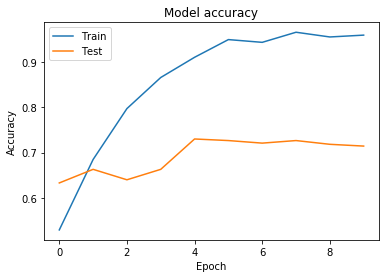

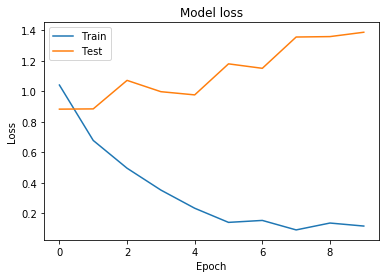

In [25]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()